![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Dasymetic Mapping for City of Chesapeake, Viginia

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser.

 - <b>Products used</b>:
    - OpenStreetMap
    - American Community Survey from U.S. Census Bureau - Census Tract Level
    - National Land Cover Database from U.S. Geological Survey (Now saved in directory, to be uploaded to VA Datacube) 
    
 - <b>Special requirements:</b> 
    A python code, join_donuts.py is applied in this notebook, please make sure to include it in the directory. 
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube.


## Background 

The goal of this notebook is to explore dasymetric mapping in City of Chesapeake, Virginia.

Dasymetric mapping is a technique often used to remap populations from census tracts or blocks to a grid based format. In the United States, census data is widely used to analyze the spatial distribution of socio-economic factors. For instance, the American Community Survey (ACS, available at https://www.census.gov/programs-surveys/acs) compiles crucial socio-economic data at the census tract level. Census boundaries can cover a diverse set of zones, from industrial to residential. Human populations are not evenly distributed and tend to concentrate in residential areas. Dasymetric mapping, in combination with other datasets like land use and land cover, enhances the precision of mapping results based on this logic.



## Description

This notebook applies a python package, Tobler, for dasymetric mapping, for more information, please refer to https://github.com/pysal/tobler.

The steps are as follows:
1. Load OpenStreetMap data for the residential area.
2. Load population data from the U.S. Census Bureau.
3. Load land use and land cover data from the National Land Cover Database.
4. Apply interpolation methods.
5. Create an interactive map.

In [1]:
# Import Data Cube related library
import datacube
from deafrica_tools.plotting import rgb, display_map

# Import required python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap # for land use land cover plotting
#from mpl_toolkits.axes_grid1 import make_axes_locatable # imporve plotting

# Geospatial related
import geopandas as gpd
import cenpy # for census data
import osmnx as ox # for OpenStreetMap data
import rioxarray
from rasterio.plot import show
from shapely.geometry import Polygon, LineString, Point
from join_donuts import join_donuts # This function require the join_donuts.py in local folder
from split_donuts import split_donuts # This function require the split_donuts.py in local folder

# Geostatistic for dasymetric mapping 
import pysal
from tobler.area_weighted import area_interpolate
from tobler.dasymetric import masked_area_interpolate
from tobler.model import glm

# Interactive mapping
import folium
from folium import plugins

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

## 1. Load Residential OpenStreetMap data

OpenStreetMap (OSM) is a collaborative, open-source mapping project. With a global community of contributors, OSM provides a free and constantly evolving map of the world. The python library, osmnx, can be applied to retrieve residential areas. These represent an area of land having predominantly residential buildings such as houses or apartments. 

For more information about OSM data, please see:
- osmnx python library: https://osmnx.readthedocs.io/en/stable/
- OSM residential area: https://wiki.openstreetmap.org/wiki/Tag:landuse%3Dresidential

In [2]:
# Load OpenStreetMap (OSM) data for Cit of Chesapeake
cpc_ox_resi = ox.features.features_from_place ('Chesapeake,Virginia', tags={'landuse':'residential'})

# Remove the non-polygon part of data
cpc_ox_resi = cpc_ox_resi.loc[cpc_ox_resi.geometry.type=='Polygon'] 

# Convert to UTM coordinate system
cpc_ox_resi = cpc_ox_resi.to_crs("epsg:32618")

Some of the OSM residential data contain complex polygon shapes, including polygons with holes (referred to as "donuts"). These intricate polygons do not function well with one of the Tobler functions. To address this, we have introduced an additional function called "join_donuts" to simplify these polygons. For more information on the "join_donuts" function, please visit: https://github.com/fgassert/split_donuts/tree/master

In [3]:
# Save OSM data to a shpefile
# Filter column to avoid error (see: https://pygis.io/docs/d_access_osm.html)
cpc_ox_resi  = cpc_ox_resi.loc[:,cpc_ox_resi.columns.str.contains('addr:|geometry')] 
cpc_ox_resi.to_file ("cpc_ox_resi_ori.shp") 

# Run join donuts function and load it back to a geodataframe
# Hide shapely warning messages
import warnings 
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

join_donuts("cpc_ox_resi_ori.shp", "cpc_ox_resi_fixed.shp")
cpc_ox_resi_fixed = gpd.read_file("cpc_ox_resi_fixed.shp")

# Another way to fix donut polygons, feel free to try split donut function
#split_donuts("cpc_ox_resi_ori.shp", "cpc_ox_resi_fixed.shp")
#cpc_ox_resi_fixed = gpd.read_file("cpc_ox_resi_fixed.shp")

/tmp/ipykernel_203257/414387692.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cpc_ox_resi.to_file ("cpc_ox_resi_ori.shp")


Text(0.5, 1.0, 'OpenStreetMap Residential Area')

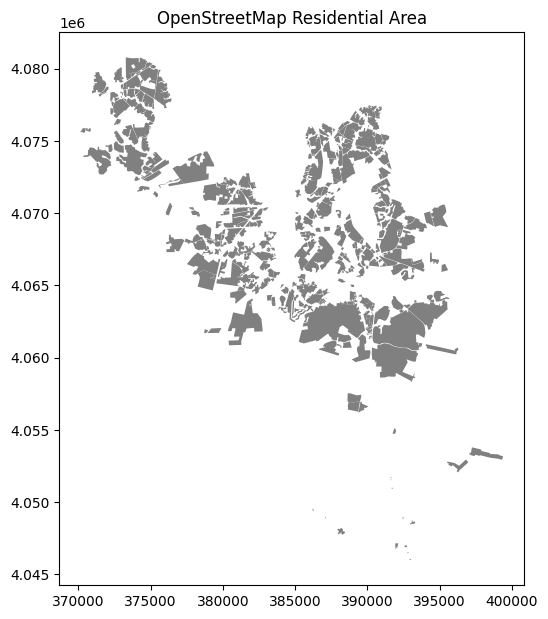

In [4]:
# Plot the OSM residential area
f,ax = plt.subplots(1,1, figsize=(6,8))
cpc_ox_resi_fixed.plot(linewidth=.25, ax=ax, color='gray')
ax.set_title("OpenStreetMap Residential Area")

## 2. Load Population Data from the U.S. Census Bureau

You can access the American Community Survey (ACS) data using Cenpy, a Python library specifically created for loading U.S. census data. ACS data is organized by census tracts, each of which encompasses a population of roughly 1,200 to 8,000 people. In this case, we're retrieving the 2019 data, which is the most up-to-date information available in the Cenpy database. For additional details about Cenpy, please visit: http://cenpy-devs.github.io/cenpy/index.html

In [5]:
# Retrieve ACS data for City of Chesapeake
cpc_pop = cenpy.products.ACS(2019).from_county('Chesapeake,VA', variables=['B02001_001E'])
cpc_pop = cpc_pop.rename(columns={'B02001_001E':'Total_population'})
cpc_pop = cpc_pop.to_crs("epsg:32618") # Convert to UTM coordinate system

# Calculate population density based on the original census tract boundary
cpc_pop['Area (sq. km)'] = (cpc_pop.geometry.area) / 1000000
cpc_pop['Population_density_original'] = cpc_pop['Total_population'] / cpc_pop['Area (sq. km)']

/opt/tljh/user/lib/python3.9/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)


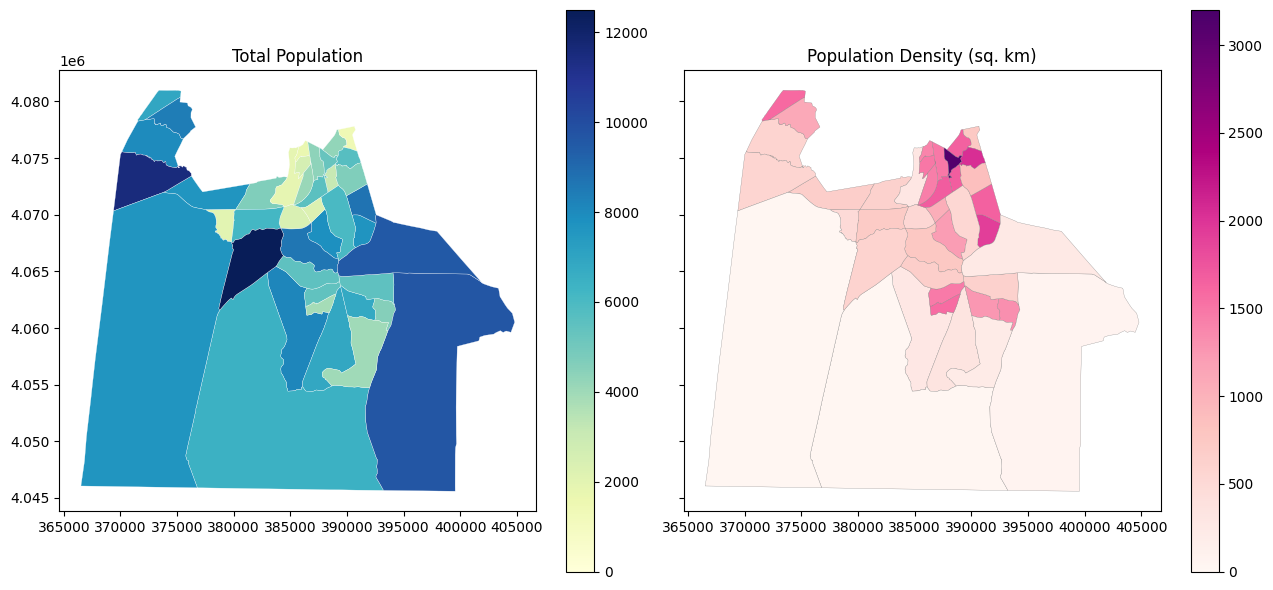

In [6]:
# Plot census tract data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

ax1 = cpc_pop.plot(ax=ax1, column = 'Total_population', legend=True, edgecolor="white", 
                   linewidth=0.2, vmin=0, vmax=12500, cmap='YlGnBu')
ax1.set_title("Total Population")
ax2 = cpc_pop.plot(ax=ax2, column = 'Population_density_original', legend=True, edgecolor="gray", 
                   linewidth=0.2, vmin=0, vmax=3200, cmap='RdPu')
ax2.set_title("Population Density (sq. km)")
plt.tight_layout()

In [7]:
# Create an AOI for data loading and clipping in later section
AOI = cpc_pop.copy()
AOI['disso'] = 1
AOI = AOI.dissolve(by='disso')
AOI = AOI.to_crs("epsg:4326") # Save it to WGS 84 coordinate

## 3. Load land use / land cover data from the National Land Cover Database

The National Land Cover Database (NLCD) offers comprehensive land cover and land use data for the entire United States. If you'd like to learn more about NLCD, you can visit their website here: https://www.usgs.gov/centers/eros/science/national-land-cover-database

The 2019 NLCD for Chesapeake City is load from VA Data Cube for dasymetric mapping

In [8]:
# Define datacube and area of interest
dc = datacube.Datacube(app='Dasymap_tobler')

# Define a boundary to load data
AOI_boundary = AOI.total_bounds
lat_range = (AOI_boundary[1],AOI_boundary[3])
lon_range = (AOI_boundary[0],AOI_boundary[2])

# Make a quitck plot to show the AOI boundary
display_map(lon_range, lat_range)

/opt/tljh/user/lib/python3.9/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


In [9]:
# Load nlcd from VA DataCube
query = {
    "y": lat_range,
    "x": lon_range,
    #"time": time_range,
}

lc = dc.load(
    product= "usgs_nlcd", #"io_lulc"
    output_crs="epsg:32618", # UTM 18N
    resolution=(-30, 30),
    **query,
    skip_broken_datasets=True
)

# Print available years for the nlcd data, note the year of nlcd data
lc.coords["time"]

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.DataArray 'time' (time: 9)>
array(['2001-10-07T12:00:00.000000000', '2004-10-07T12:00:00.000000000',
       '2006-10-07T12:00:00.000000000', '2008-10-07T12:00:00.000000000',
       '2011-10-07T12:00:00.000000000', '2013-10-07T12:00:00.000000000',
       '2016-10-07T12:00:00.000000000', '2019-10-07T12:00:00.000000000',
       '2021-10-07T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2001-10-07T12:00:00 ... 2021-10-07T12:...
    spatial_ref  int32 32618
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [10]:
lc2d = lc.isel(time=7) # this call 2019 nlcd data
lc2d

<xarray.Dataset>
Dimensions:         (y: 1186, x: 1284)
Coordinates:
    time            datetime64[ns] 2019-10-07T12:00:00
  * y               (y) float64 4.081e+06 4.081e+06 ... 4.046e+06 4.046e+06
  * x               (x) float64 3.665e+05 3.666e+05 ... 4.05e+05 4.05e+05
    spatial_ref     int32 32618
Data variables:
    classification  (y, x) uint8 21 22 22 22 22 22 22 ... 90 90 90 90 90 90 90
Attributes:
    crs:           epsg:32618
    grid_mapping:  spatial_ref

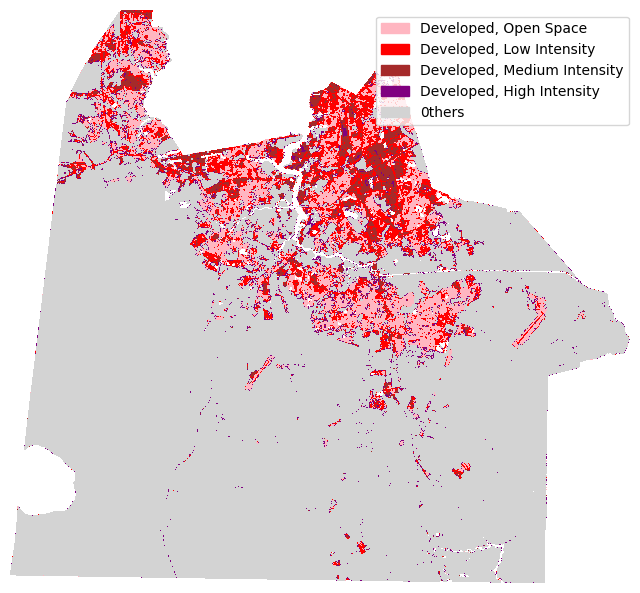

In [11]:
# plot the nlcd data
lc2dAOI = lc2d.rio.clip(AOI.geometry.values, AOI.crs) # clip  the nlcd data to AOI
lc2darray = lc2dAOI.to_array().squeeze() # flat the dimension

# Create a color map and call specific classification for visualization
cmap = ListedColormap(["white", "lightpink", "red", "brown", "purple", "lightgray"])
norm = colors.BoundaryNorm([11, 21, 22, 23, 24, 31, 52], 7) # This define the classes

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(lc2darray, cmap=cmap, norm=norm)
legend_labels = {"lightpink": "Developed, Open Space",  # Create a legend to indicate the land use land cover type
                 "red": "Developed, Low Intensity", 
                 "brown": "Developed, Medium Intensity",
                 "purple": "Developed, High Intensity",
                 "lightgray": "0thers"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches, bbox_to_anchor=(1.01, 1), facecolor="white")
ax.set_axis_off() # Not plotting the X and Y becuase imshow does not plot with UTM X and Y values
plt.show()

## 4. Apply interpolation methods

One aim of Dasymetric mapping can be to focus on residential areas. We applied the Tobler library for interpolation, which uses data from census tracts, residential areas, and land use land cover data. In Tobler, there are three mapping methods that we will apply and compare:

1. Generalized Linear Model (GLM): A statistic modeling method that consider the relationship between the target variable and a set of covariates characteristics.

2. Areal Interpolation (AI): The simplest method for allocating variables based on overlapping geometries.

3. Masked Area Interpolation (MAI): Similar to areal interpolation, this method incorporates auxiliary data (e.g., NLCD) to enhance estimations.

In [12]:
# Save nlcd data as a tif file for Tobler function
lc2darray.rio.to_raster("nlcd2016.tif")
nlcd_cpcfile = "./nlcd2016.tif"

# Apply Generalized Linear Model (GLM) method
glm_popden_oxres = glm(source_df=cpc_pop, target_df=cpc_ox_resi_fixed, 
                       raster=nlcd_cpcfile, raster_codes=[21, 22, 23, 24], 
                       variable="Total_population")
glm_popden_oxres["area"] = glm_popden_oxres["geometry"].area/ 1000000
glm_popden_oxres["Population_density_glm"] = glm_popden_oxres["Total_population"] / glm_popden_oxres["area"]
glm_popden_oxres = glm_popden_oxres.rename(columns ={"Total_population":'Total_population_glm'})

# Apply Areal Interpolation (AI) method
AI_popden_oxres = area_interpolate(source_df=cpc_pop, target_df=cpc_ox_resi_fixed, 
                                   extensive_variables=['Total_population'])
AI_popden_oxres["area"] = AI_popden_oxres["geometry"].area/ 1000000
AI_popden_oxres["Population_density_AI"] = AI_popden_oxres["Total_population"] / AI_popden_oxres["area"]
AI_popden_oxres = AI_popden_oxres.rename(columns ={"Total_population":"Total_population_AI"})

# Apply Masked Areal Interpolation (MAI) method
MAI_popden_oxres = masked_area_interpolate (source_df=cpc_pop, target_df=cpc_ox_resi_fixed, 
                                            raster=nlcd_cpcfile, pixel_values=[21, 22, 23, 24],
                                            extensive_variables=["Total_population"])
MAI_popden_oxres["area"] = MAI_popden_oxres["geometry"].area/ 1000000
MAI_popden_oxres["Population_density_MAI"] = MAI_popden_oxres["Total_population"] / MAI_popden_oxres["area"]
MAI_popden_oxres = MAI_popden_oxres.rename(columns ={"Total_population":"Total_population_MAI"})


/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/tljh/user/lib/python3.9/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:153

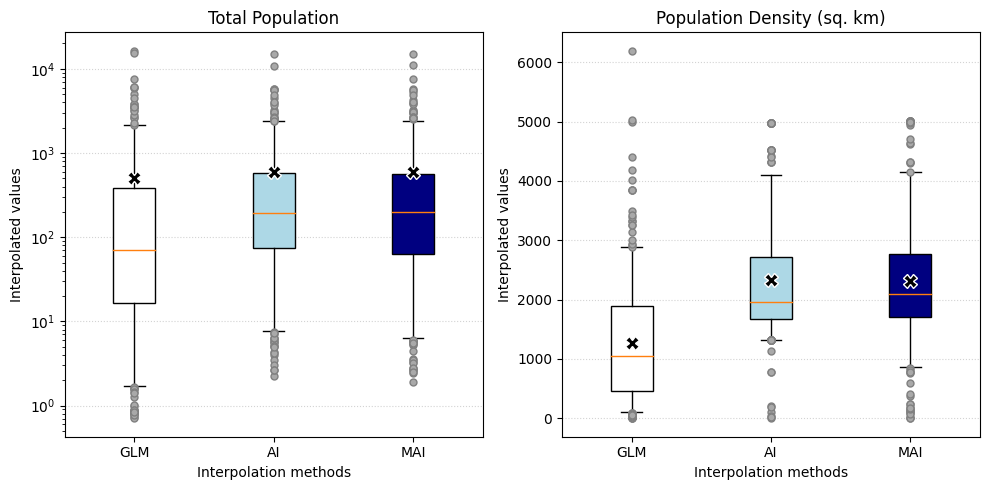

In [13]:
# Clean up the geodataframes and merge them into one dataframe
resultdf = glm_popden_oxres.merge(AI_popden_oxres, left_index=True, right_index=True).merge(MAI_popden_oxres, left_index=True, right_index=True)
resultdf = resultdf [["geometry","Total_population_glm", "Total_population_AI", "Total_population_MAI",
                     "Population_density_glm", "Population_density_AI", "Population_density_MAI"]]

# Create boxplots to show the data distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# Set styles for outlier and mean
flierprops = dict(marker='.', markerfacecolor='darkgray', markersize=10,
                  markeredgecolor="gray")
meanpointprops = dict(marker='X', markeredgecolor='white', markersize=10,
                      markerfacecolor='black')

labels = ["GLM", "AI", "MAI"]
bplot1 = ax1.boxplot(resultdf [["Total_population_glm", "Total_population_AI", "Total_population_MAI"]],
                     vert=True, flierprops=flierprops, meanprops=meanpointprops,
                     showmeans = True, patch_artist=True, whis = (5,95), # whisker showing 5 and 95 percentiles
                     labels=labels) 
ax1.set_yscale('log')
ax1.set_title("Total Population")

bplot2 = ax2.boxplot(resultdf [["Population_density_glm", "Population_density_AI", "Population_density_MAI"]],
                     vert=True, flierprops=flierprops, meanprops=meanpointprops,
                     showmeans = True, patch_artist=True, whis = (5,95), # whisker showing 5 and 95 percentiles
                     labels=labels) 
ax2.set_title("Population Density (sq. km)")

# Set colors of boxs
colors = ["white", "lightblue", "navy"]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

# Add grid-line and x & y labels
for ax in [ax1, ax2]:
    ax.yaxis.grid(color="lightgray", linestyle="dotted")
    ax.set_xlabel("Interpolation methods")
    ax.set_ylabel("Interpolated values")

plt.tight_layout()

/tmp/ipykernel_203257/3937462138.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


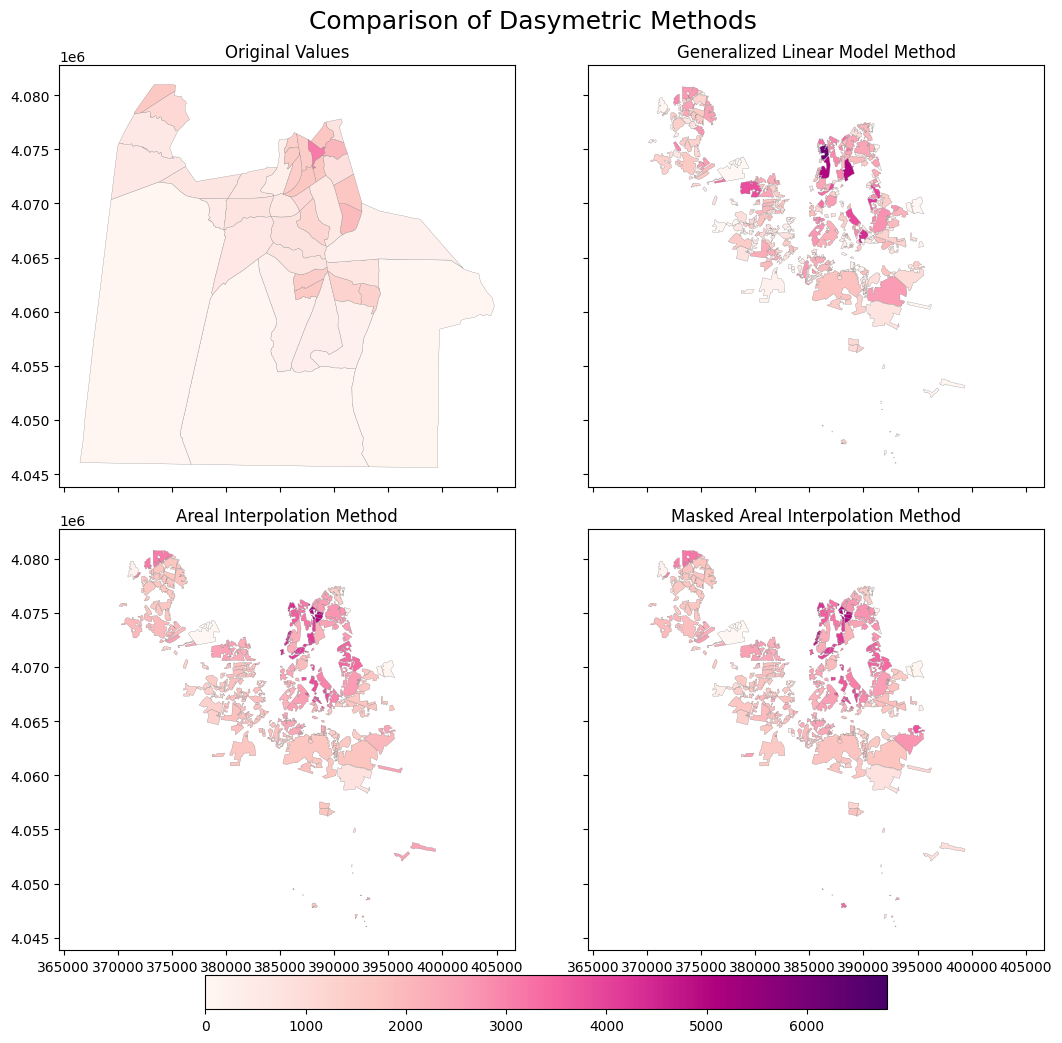

In [14]:
# Make a side-by-side map showing the outcomes
fig, axs = plt.subplots(2, 2, figsize=(11, 10), sharex=True, sharey=True)
fig.suptitle ("Comparison of Dasymetric Methods",  fontsize=18)

# Define the minimum and maximum values for plotting
vmin = 0
vmax = 6800

# Plot original data
axs[0,0] = cpc_pop.plot(ax=axs[0][0], column = 'Population_density_original', edgecolor="gray", 
                        linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[0,0].set_title("Original Values")

# Plot Generalized Linear Model result
axs[0,1] = glm_popden_oxres.plot(ax=axs[0][1],column = 'Population_density_glm', edgecolor="gray", 
                                        linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[0,1].set_title("Generalized Linear Model Method")

# Plot Areal Interpolation result
axs[1,0] = AI_popden_oxres.plot(ax=axs[1][0], column = 'Population_density_AI', edgecolor="gray", 
                                linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[1,0].set_title("Areal Interpolation Method")

# Plot Masked Areal Interpolation result
axs[1,1] = MAI_popden_oxres.plot(ax=axs[1][1], column = 'Population_density_MAI', edgecolor="gray", 
                                 linewidth=0.2, vmin=vmin, vmax=vmax, cmap='RdPu')
axs[1,1].set_title("Masked Areal Interpolation Method")

# Define color bar on the bottom
patch_col = axs[0,0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, orientation='horizontal', shrink= 0.8, location = "bottom", anchor=(0.5, -1.6))
plt.subplots_adjust(bottom=0.1)

plt.tight_layout()


## 5. Create an Interactive Map

In [15]:
# Create a folium map 
m = folium.Map(location=[36.72, -76.30], zoom_start=11, tiles="cartodbpositron")

# Call two basemap layers and add to the map
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}
basemaps['Google Maps'].add_to(m)
basemaps['Google Satellite'].add_to(m)

myscale = np.linspace(vmin, vmax, 6) # Set-up mapping scale, here we use the vmin and vmax values from the side-by-side map
resultdf = resultdf.reset_index() # Re-set index for folium map function

# Map three dasymetric outcomes
folium.Choropleth(geo_data = cpc_ox_resi_fixed,
                  data = resultdf,
                  name='MAI', 
                  key_on="feature.id",
                  columns=["index","Population_density_MAI"],
                  threshold_scale=myscale,
                  fill_color='RdPu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  legend_name="MAI, Population Density (people / square km)"
                 ).add_to(m)

folium.Choropleth(geo_data = cpc_ox_resi_fixed,
                  data = resultdf,
                  name='AI', 
                  key_on="feature.id",
                  columns=["index","Population_density_AI"],
                  threshold_scale=myscale,
                  fill_color='RdPu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  legend_name="AI, Population Density (people / square km)"
                 ).add_to(m)

folium.Choropleth(geo_data = cpc_ox_resi_fixed,
                  data = resultdf,
                  name='GLM', 
                  key_on="feature.id",
                  columns=["index","Population_density_glm"],
                  threshold_scale=myscale,
                  fill_color='RdPu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  legend_name="GLM, Population Density (people / square km)"
                 ).add_to(m)

# Add a layer control panel to the map, you can on/off layers from the top-right corner icon and compare their differences.
m.add_child(folium.LayerControl())
m

/opt/tljh/user/lib/python3.9/site-packages/folium/features.py:1465: DeprecationWarning: choropleth `threshold_scale` parameter is now depreciated in favor of the `bins` parameter.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/folium/features.py:1465: DeprecationWarning: choropleth `threshold_scale` parameter is now depreciated in favor of the `bins` parameter.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/folium/features.py:1465: DeprecationWarning: choropleth `threshold_scale` parameter is now depreciated in favor of the `bins` parameter.
  warnings.warn(
